#June 2018 OOI Biology Workshop Data Validation Report


This notebook will examine shelf and off-shelf profilers located on the Endurace Array off Newport, Oregon, USA. The goal is to compare independent measurements collected by the Peterson group based out of HMSC in Newport, Oregon. I will compare temperature, salinity, and dissolved oxygen measurements. The Peterson group conducts bi-weekly cruises at 7 stations along the Newport Line from 1-25 miles off shore.  The shelf stations for the Newport Line sampling (NH-5) (44.6517, -124.1770) and OOI moorings (44.641, -124.3022) are seperated by 5 nm. The off-shelf station operated by OOI has a shallow profiler mooring that we can compare individual CTD casts. Again, the Peterson group station (NH-25) is inshore of the OOI sampling station.  ![alt text](http://oceanobservatories.org/wp-content/uploads/2018/03/EA_WAOR_2018_labels.png)

## Using asynchronous data request Oregon Shelf Surface Profilier Mooring and NH-05 CTD Cast

Now that we have our profiler of interest, let's take a look at the instruments at the OOI Data Team Portal to get an idea of what we are working with. We want to get data from reference designator CE02SHSP-SP001-01-DOSTAJ000. Important lesson: Auxilliary sensors, such as DO and fluorometers will have CTD interpolated pressure, temperature, and salinity. In order to compare these physical parameters to independent CTD casts, I only need to request data from the dissolved oxygen sensor. Looking at the data portal, the data availability is sparse. Decided to focus on September 2016, specifially Sept 6th. Now it's time to request available data. 

In [31]:
# Setup Instrument Variables
site = 'CE02SHSP'
node = 'SP001'
instrument = '01-DOSTAJ000'
method = 'recovered_cspp'
stream = 'dosta_abcdjm_cspp_instrument_recovered'

In [32]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd

In [33]:
# API Information
USERNAME ='OOIAPI-Y4VVWHNQL1983S'
TOKEN= 'Q9LA7YR8PRQSGK'
DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'

In [7]:
whos

Variable                  Type        Data/Info
-----------------------------------------------
ASSET_API                 str         https://ooinet.oceanobser<...>atories.org/api/m2m/12587
DATA_API                  str         https://ooinet.oceanobser<...>/api/m2m/12576/sensor/inv
TOKEN                     str         Q9LA7YR8PRQSGK
USERNAME                  str         OOIAPI-Y4VVWHNQL1983S
VOCAB_API                 str         https://ooinet.oceanobser<...>g/api/m2m/12586/vocab/inv
convert_time              function    <function convert_time at 0x7efe780cda28>
datetime                  module      <module 'datetime' (built-in)>
instrument                str         01-DOSTAJ000
method                    str         recovered_cspp
node                      str         SP001
ntp_delta                 float       2208988800.0
ntp_epoch                 datetime    1900-01-01 00:00:00
ntp_seconds_to_datetime   function    <function ntp_seconds_to_<...>tetime at 0x7efe780cdd70>
pd       

In [34]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None

In [35]:
# Setup the API request url
data_request_url ='/'.join((VOCAB_API,site,node,instrument))
print data_request_url

# Grab the information from the server
r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
data = r.json()
data

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/CE02SHSP/SP001/01-DOSTAJ000


[{u'@class': u'.VocabRecord',
  u'instrument': u'Dissolved Oxygen',
  u'manufacturer': u'Aanderaa',
  u'maxdepth': 80.0,
  u'mindepth': 0.0,
  u'model': u'Optode 4831',
  u'refdes': u'CE02SHSP-SP001-01-DOSTAJ000',
  u'tocL1': u'Coastal Endurance',
  u'tocL2': u'Oregon Shelf Surface Piercing Profiler Mooring',
  u'tocL3': u'Surface Piercing Profiler',
  u'vocabId': 94}]

Looks like we have the right information!

In [36]:
# Setup the API request url
data_request_url = ASSET_API + '/events/deployment/query'
params = {
  'beginDT':'2016-01-01T00:00:00.000Z',
  'endDT':'2016-12-25T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+instrument,   
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,1732.0,1.0,44.63910,-124.300430,CGINS-DOSTAJ-00209,2015-03-18 19:20:00,2015-04-02 00:00:00
1,195.0,3.0,44.63781,-124.311120,CGINS-DOSTAD-00314,2016-08-23 18:00:00,2016-10-02 16:52:00
2,1732.0,4.0,44.63890,-124.299033,CGINS-DOSTAJ-00209,2016-10-11 19:03:00,2017-01-06 00:00:00


Looking at deployments between Jan. 2016- Dec. 2016. 

Let's take a look at annotations, but for a longer time period.

In [37]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT':int(datetime.date(2016,1,1).strftime('%s'))*1000,
  'endDT':int(datetime.date(2017,12,25).strftime('%s'))*1000,
  'refdes':site+'-'+node+'-'+instrument,
}

r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,"The main batteries on CE02SHSP-00005 drained this week unexpectedly. CSPPs are deployed at 33.4 V. Voltage drops roughly linearly with each profile. Batteries were at 31 V at the beginning of this week. Yesterday (2017-03-09), it reported via acoustic modem that it was in a LOW POWER state, which it does automatically at 28 V to protect the main batteries. In the past, similar drains have been due to faulty connections between the main batteries and the profilers at the battery adapter plates. This has been the CSPP's main failure behavior.\r\r\n\r\r\nThis profiler should be OK to leave where it is until planned recovery in mid-April, but it would better to recover it sooner. It is 31 lbs. buoyant and it has a working Iridium beacon. We're ranging to its acoustic modem daily from CE02SHSM.\r\r\n",882.0,None,None,CE02SHSP,2017-03-09,2017-04-18
1,"CE02SHSP-00006 reported that it had surfaced unexpectedly April 25 at 5:10 pm local time. Within a few hours I determined that it was still tethered to its anchor. It's beacon wasn't reporting either. We recovered the profiler and its anchor the following day.Data were sent to the profiler vendor and to CI. By April 28 we confirmed there was a firmware bug that had never been seen before. While scooching between two positions, the control canister thought the profiler was 20 cm below its destination, but the profiler's winch thought the profiler was 20 cm above its destination, so the profiler was winched up to the surface, instead of retreating 20 cm to its parking depth. The bug will be corrected in the next firmware release.It also turns out that I had programmed the beacon improperly, so it had run out of batteries. We switched to a new beacon model this year. I confirmed with the vendor which settings to use.Redeployment is planned for May 19, 2017.------------------------------------------------------------------------------------------------Communications to the acoustic modem on the neighboring surface mooring just went down, so I recommend not redeploying a CSPP here until the mooring is turned.- Jon Fram",883.0,None,None,CE02SHSP,2017-04-25,2017-10-05


Time to import more packages to plot and format data.

In [38]:
import matplotlib.pyplot as plt

!pip install netCDF4
import netCDF4 as nc

!pip install xarray
import xarray as xr

!pip install cmocean
import cmocean

In an effort to try different ways or requesting data, I used the Data Portal to request data for the DO sensor from August 26, 2016- October 2, 2016. I copied the url from my email. 

In [39]:
data_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/zemans-oregonstate-edu/20180621T190500-CE02SHSP-SP001-01-DOSTAJ000-recovered_cspp-dosta_abcdjm_cspp_instrument_recovered/deployment0003_CE02SHSP-SP001-01-DOSTAJ000-recovered_cspp-dosta_abcdjm_cspp_instrument_recovered_20160823T182628.916000-20161002T143541.103000.nc'
ds = xr.open_dataset(data_url)

# Swap the dimensions
ds = ds.swap_dims({'obs': 'time'})
ds

<xarray.Dataset>
Dimensions:                                     (time: 35317)
Coordinates:
    obs                                         (time) int32 0 1 2 3 4 5 6 7 ...
  * time                                        (time) datetime64[ns] 2016-08-23T18:26:28.915999744 ...
    pressure_depth                              (time) float32 ...
    lat                                         (time) float64 ...
    lon                                         (time) float64 ...
Data variables:
    deployment                                  (time) int32 ...
    id                                          (time) |S64 ...
    blue_amplitude                              (time) float32 ...
    blue_phase                                  (time) float32 ...
    calibrated_phase                            (time) float32 ...
    driver_timestamp                            (time) datetime64[ns] ...
    estimated_oxygen_concentration              (time) float32 ...
    estimated_oxygen_saturation    

We loaded in the data!

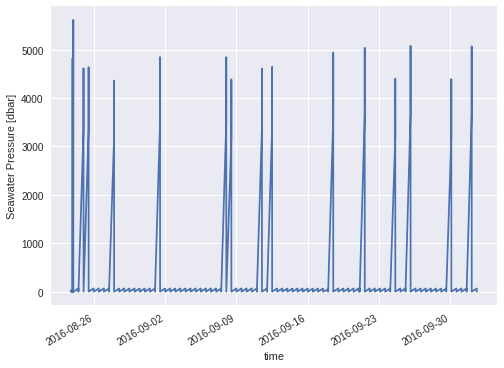

In [40]:
#Simple plot of pressure over Sept 2016
ds['int_ctd_pressure'].plot()

Making a quick plot of pressure. Those are some large dbar readings considering this profiler is in 80 meters of water! Call pressure variable to make sure in dbar.

In [16]:
ds['int_ctd_pressure']


<xarray.DataArray 'int_ctd_pressure' (time: 35317)>
array([22.792203, 22.702572, 22.626017, ...,  1.277406,  1.167048,  0.98765 ])
Coordinates:
    obs             (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time            (time) datetime64[ns] 2016-08-23T18:26:28.915999744 ...
    pressure_depth  (time) float32 22.793 22.698 22.623 22.569 22.524 22.464 ...
    lat             (time) float64 44.64 44.64 44.64 44.64 44.64 44.64 44.64 ...
    lon             (time) float64 -124.3 -124.3 -124.3 -124.3 -124.3 -124.3 ...
Attributes:
    comment:                  Seawater Pressure refers to the pressure exerte...
    data_product_identifier:  PRESWAT_L1
    precision:                3
    long_name:                Seawater Pressure
    standard_name:            sea_water_pressure
    units:                    dbar
    _ChunkSizes:              10000

Units are in dbar. Large spikes are outliers? 

In [41]:
# Extract the values
dtime = ds['time'].values
pressure = ds['int_ctd_pressure'].values
temperature = ds['temperature'].values
salinity = ds['salinity'].values
oxygen=ds['dissolved_oxygen'].values


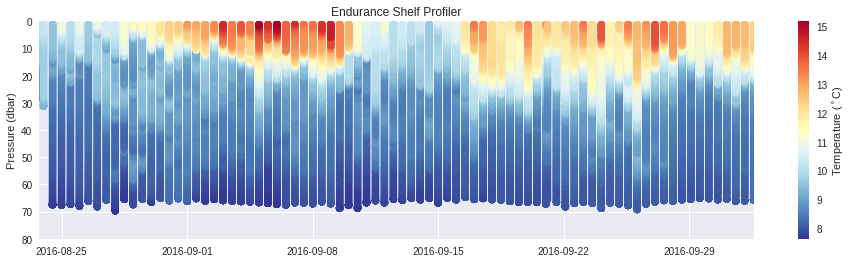

In [42]:
# Scatterplot of Temperature
fig,ax1 = plt.subplots(1,1,figsize=(16,4))
sc1 = ax1.scatter(dtime, pressure,c=temperature, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Endurance Shelf Profiler');
ax1.set_ylim([0, 80])
ax1.invert_yaxis() # Invert y axis


Trying out a scatterplot of temperature from end of Aug-Sept 2016. Interesting 'hot spots' at the surface with temperatures ~15 degrees. This was during the Warm Blob so temperatures make sense. Also compared briefly to the NDBC Buoy 46050 located off Newport, OR.

(array([1.9200e+02, 3.4504e+04, 0.0000e+00, 1.0000e+00, 1.2000e+01,
        0.0000e+00, 2.2800e+02, 2.9100e+02, 6.7000e+01, 2.2000e+01]),
 array([  6.28498985,  20.759349  ,  35.23370815,  49.7080673 ,
         64.18242645,  78.6567856 ,  93.13114474, 107.60550389,
        122.07986304, 136.55422219, 151.02858134]),
 <a list of 10 Patch objects>)

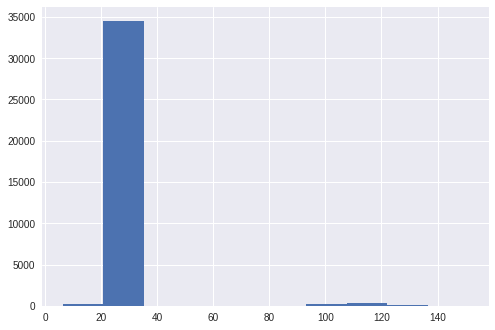

In [49]:
plt.hist(salinity)

Seeing large outliers in salinity.

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.3212e+04, 1.1809e+04, 9.0340e+03, 1.2610e+03]),
 array([-319.02494424, -259.66162402, -200.29830379, -140.93498356,
         -81.57166334,  -22.20834311,   37.15497711,   96.51829734,
         155.88161756,  215.24493779,  274.60825801]),
 <a list of 10 Patch objects>)

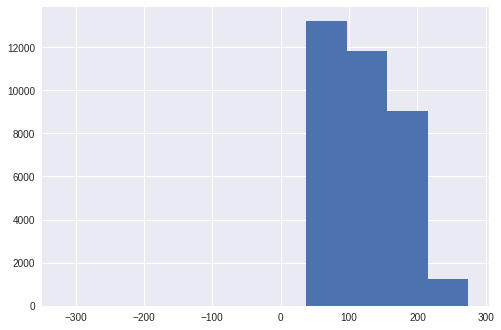

In [67]:
plt.hist(oxygen)

Also see some negative dissolved oxygen measurements. 

In [69]:
print "Max value element salinity : ", max(salinity)
print "Max value element oxygen : ",max(oxygen)
print "Min value element oxygen : ",min(oxygen)
print "Min value element salinity", min(salinity)

Max value element salinity :  151.02858133953097
Max value element oxygen :  274.6082580136713
Min value element oxygen :  -319.02494424129344
Min value element salinity 6.284989852546243


In [43]:
!pip install cmocean
import cmocean

Profiles of Temperature, salinity, and oxygen from Sept. 2016.

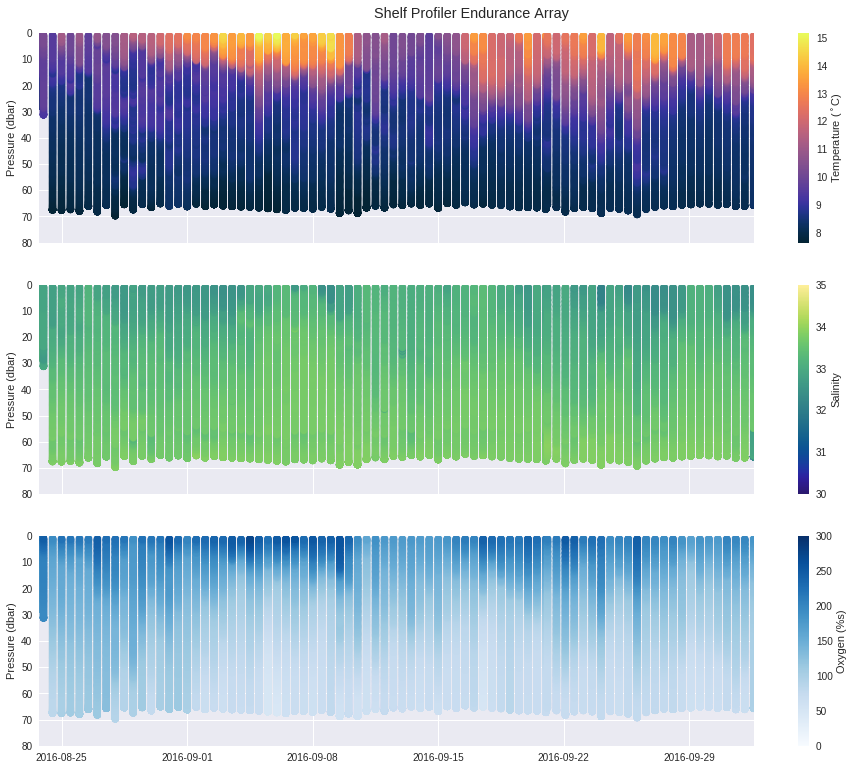

In [44]:
#Temperature, Salinity & Oxygen
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(16,12))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap=cmocean.cm.thermal) 
sc2 = ax2.scatter(dtime, pressure, c=salinity,cmap=cmocean.cm.haline,vmin=30,vmax=35) 
sc3 = ax3.scatter(dtime, pressure, c=oxygen, cmap='Blues',vmin=0,vmax=300)

# Because the X and Y axes are shared, we only have to set limits once
ax1.set_ylim([0, 80])
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

# Add the colorbars
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2,orientation='vertical')
cbar.ax.set_ylabel('Salinity')
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical')
cbar.ax.set_ylabel('Oxygen (%s)' % ds['corrected_dissolved_oxygen'].units)
cbar.update_ticks()
cbar.formatter.set_useOffset(False)

# Add labels & titles
ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')
ax3.set_ylabel('Pressure (dbar)')

fig.suptitle('Shelf Profiler Endurance Array')
fig.subplots_adjust(top=0.95);


In [0]:
import matplotlib.pyplot as plt
import numpy as np

Alright, let's take a look at a specific day.

In [49]:
a = ds.sel(time=slice('2016-09-06', '2016-09-07'))
a

<xarray.Dataset>
Dimensions:                                     (time: 1571)
Coordinates:
    obs                                         (time) int32 14016 14017 ...
  * time                                        (time) datetime64[ns] 2016-09-06T00:15:41.111000064 ...
    pressure_depth                              (time) float32 ...
    lat                                         (time) float64 ...
    lon                                         (time) float64 ...
Data variables:
    deployment                                  (time) int32 ...
    id                                          (time) |S64 ...
    blue_amplitude                              (time) float32 ...
    blue_phase                                  (time) float32 ...
    calibrated_phase                            (time) float32 ...
    driver_timestamp                            (time) datetime64[ns] ...
    estimated_oxygen_concentration              (time) float32 ...
    estimated_oxygen_saturation         

In [46]:
print(ds.time.size)
print(a.time.size)

35317
1571


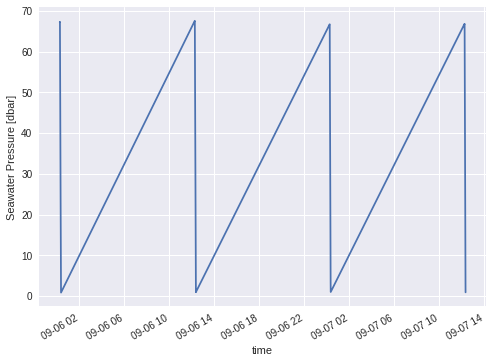

In [50]:
# A quickplot
a['int_ctd_pressure'].plot();

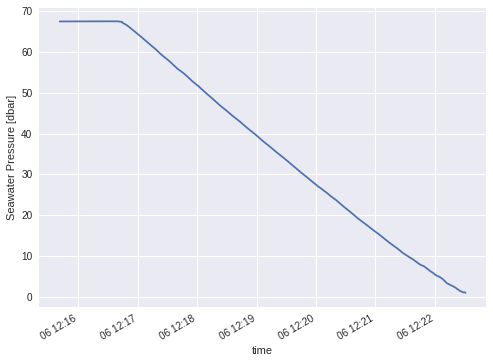

In [44]:
# Extract a full up or down cast
ds2 = ds.sel(time=slice('2016-09-06 10:35:00', '2016-09-06 23:45:00'))
ds2['int_ctd_pressure'].plot();


Text(0.5,0.98,u'Endurance Shelf Profiler Sept 6 2016')

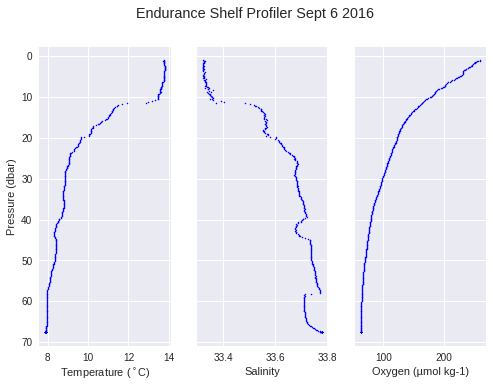

In [45]:
# Now let's create some vertical profile plots
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)

ax1.plot(ds2.temperature, ds2.int_ctd_pressure, 'b.', markersize=3)
ax2.plot(ds2.salinity, ds2.int_ctd_pressure, 'b.', markersize=3)
ax3.plot(ds2.dissolved_oxygen,ds2.int_ctd_pressure,'.b',markersize=3)


ax1.set_xlabel('Temperature ($^\circ$C)')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('Oxygen (%s)' % ds['dissolved_oxygen'].units)

ax1.set_ylabel('Pressure (dbar)')

ax1.invert_yaxis()
fig.suptitle('Endurance Shelf Profiler Sept 6 2016')
# ax1.set_ylim(475,0)



Profiles look okay. Again, seeing the high temperatures at the surface with some stratification in the upper water column. There is some wonky salinity data with peaks and dips. 


**Now, let's take a look at some Peterson Lab data. Queried our database to find a NH05 trip that happened on Sept 6, 2016. Now, how do we upload our .csv file into google colab? There looks to be a function that can take a .csv file from your google drive, but it was not working. Instead, used Sage's univerisity website to upload into the notebook to begin playing around with CTD data.** 

In [54]:
import pandas as pd

p = pd.read_csv('https://marine.rutgers.edu/~sage/OOI_Data_Workshops/NHLineData.csv')

In [59]:
p.head()

,ProjectID,CTD_Sample_Code,Station,Date,Pressure,Temperature,Conductivity,Salinity,Density,Oxygen,Fluorescence,Fluorescence mg/m3,Transmission,Transmission_volts,Comments
0,NH,090616NH05,NH05,6-Sep,1,14.5590,39.970596,32.693802,24.289301,6.9275,0.1145,NaN,92.797096,NaN,NaN
1,NH,090616NH05,NH05,6-Sep,2,13.8585,39.651424,32.997101,24.668900,7.4273,0.1031,NaN,93.020103,NaN,NaN
2,NH,090616NH05,NH05,6-Sep,3,13.7314,39.629433,33.085999,24.763599,7.6171,0.1263,NaN,92.793701,NaN,NaN
3,NH,090616NH05,NH05,6-Sep,4,13.5697,39.619926,33.216801,24.897699,7.8969,0.1527,NaN,92.389099,NaN,NaN
4,NH,090616NH05,NH05,6-Sep,5,13.5018,39.621887,33.277401,24.958300,7.7966,0.1721,NaN,91.200401,NaN,NaN


The Peterson group uses ml/L when they process oxygen data. OOI dissolved oxygen units are umol kg-1. We need to convert units in order to compare the casts. 

O2 [micromole/kg] = O2 [micromole/L] / ρ

O2 [micromole/L] = 44.6596 × O2 [ml/L]

Here, ρ is the potential density of water [kg/L] at zero pressure and at the potential
temperature (e.g., 1.0269 kg/L; e.g., UNESCO, 1983). The value of 44.6596 is derived from
the molar volume of the oxygen gas, 22.3916 L/mole, at standard temperature and pressure
(0°C, 1 atmosphere; e.g., García and Gordon, 1992).

In [27]:

p['OIIOxygen'] = p['Oxygen'].astype(float)*44.66/1.02
p.head()

,ProjectID,CTD_Sample_Code,Station,Date,Pressure,Temperature,Conductivity,Salinity,Density,Oxygen,Fluorescence,Fluorescence mg/m3,Transmission,Transmission_volts,Comments,OIIOxygen
0,NH,090616NH05,NH05,6-Sep,1,14.5590,39.970596,32.693802,24.289301,6.9275,0.1145,NaN,92.797096,NaN,NaN,303.315823
1,NH,090616NH05,NH05,6-Sep,2,13.8585,39.651424,32.997101,24.668900,7.4273,0.1031,NaN,93.020103,NaN,NaN,325.199232
2,NH,090616NH05,NH05,6-Sep,3,13.7314,39.629433,33.085999,24.763599,7.6171,0.1263,NaN,92.793701,NaN,NaN,333.509486
3,NH,090616NH05,NH05,6-Sep,4,13.5697,39.619926,33.216801,24.897699,7.8969,0.1527,NaN,92.389099,NaN,NaN,345.760355
4,NH,090616NH05,NH05,6-Sep,5,13.5018,39.621887,33.277401,24.958300,7.7966,0.1721,NaN,91.200401,NaN,NaN,341.368774


Taking out all measurements from NH-05

In [28]:
NH5=p[p.Station == 'NH05']
NH5

,ProjectID,CTD_Sample_Code,Station,Date,Pressure,Temperature,Conductivity,Salinity,Density,Oxygen,Fluorescence,Fluorescence mg/m3,Transmission,Transmission_volts,Comments,OIIOxygen
0,NH,090616NH05,NH05,6-Sep,1,14.5590,39.970596,32.693802,24.289301,6.9275,0.1145,NaN,92.797096,NaN,NaN,303.315823
1,NH,090616NH05,NH05,6-Sep,2,13.8585,39.651424,32.997101,24.668900,7.4273,0.1031,NaN,93.020103,NaN,NaN,325.199232
2,NH,090616NH05,NH05,6-Sep,3,13.7314,39.629433,33.085999,24.763599,7.6171,0.1263,NaN,92.793701,NaN,NaN,333.509486
3,NH,090616NH05,NH05,6-Sep,4,13.5697,39.619926,33.216801,24.897699,7.8969,0.1527,NaN,92.389099,NaN,NaN,345.760355
4,NH,090616NH05,NH05,6-Sep,5,13.5018,39.621887,33.277401,24.958300,7.7966,0.1721,NaN,91.200401,NaN,NaN,341.368774
5,NH,090616NH05,NH05,6-Sep,6,13.3132,39.464691,33.294201,25.009300,7.7974,0.1953,NaN,90.347702,NaN,NaN,341.403808
6,NH,090616NH05,NH05,6-Sep,7,13.0844,39.282345,33.322399,25.076900,7.7151,0.2157,NaN,89.723999,NaN,NaN,337.800351
7,NH,090616NH05,NH05,6-Sep,8,12.8261,39.069767,33.348000,25.147600,7.5903,0.2079,NaN,89.468498,NaN,NaN,332.336080
8,NH,090616NH05,NH05,6-Sep,9,12.6291,38.919239,33.378399,25.209700,7.5685,0.1975,NaN,89.752296,NaN,NaN,331.381580
9,NH,090616NH05,NH05,6-Sep,10,12.5197,38.830006,33.389599,25.239599,7.5019,0.1717,NaN,91.061203,NaN,NaN,328.465552


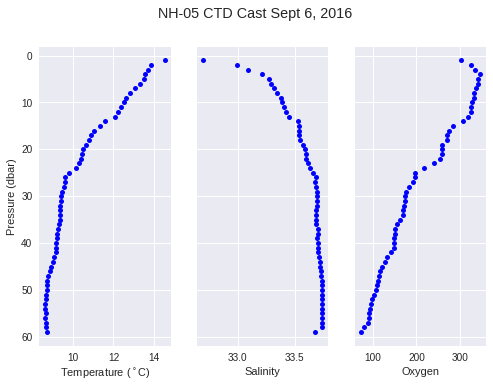

In [29]:
# Now let's create some profile plots from the Newport Line CTD at NH-05


peterpressure = NH5['Pressure'].values
petertemperature = NH5['Temperature'].values
petersalinity = NH5['Salinity'].values
peteroxygen=NH5['OIIOxygen'].values

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)

ax1.plot(petertemperature, peterpressure, 'b.', markersize=10)
ax2.plot(petersalinity, peterpressure, 'b.', markersize=10)
ax3.plot(peteroxygen,peterpressure,'b.',markersize=10)


ax1.set_xlabel('Temperature ($^\circ$C)')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('Oxygen')

ax1.set_ylabel('Pressure (dbar)')

fig.suptitle('NH-05 CTD Cast Sept 6, 2016')

ax1.invert_yaxis()

And now, let's put the OOI profiler cast with the NH-05 CTD cast

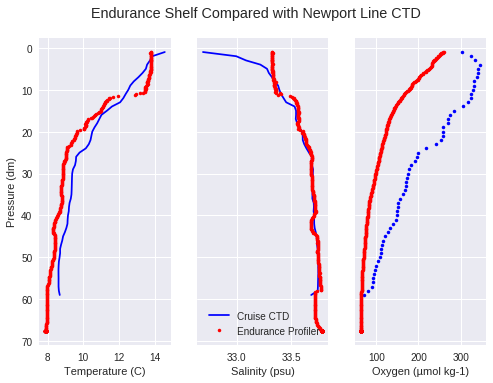

In [46]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)

ax1.plot(petertemperature,peterpressure,'b')
ax1.plot(ds2.temperature,ds2.int_ctd_pressure,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')



ax2.plot(petersalinity,peterpressure,'b',label='Cruise CTD')
ax2.plot(ds2.salinity,ds2.int_ctd_pressure,'r.',label='Endurance Profiler')
ax2.set_xlabel('Salinity (psu)')

ax3.plot(peteroxygen,peterpressure,'.b')
ax3.plot(ds2.dissolved_oxygen,ds2.int_ctd_pressure,'r.')
ax3.set_xlabel('Oxygen (%s)' % ds['dissolved_oxygen'].units)


ax1.invert_yaxis()

fig.suptitle('Endurance Shelf Compared with Newport Line CTD')
fig.subplots_adjust(top=0.9)

legend = ax2.legend(loc='lower right', shadow=True, fontsize='small')




Conclusion? 

It looks like the cruise data (blue line) and the OOI profiler (red line) track pretty well. There is some discrepancy at the surface. The dissolved oxygen profiles have an obvious offset from, with the maximum offset being ~100 umol kg-1. One important question, do we trust the oxygen censor on the Peterson group CTD? 

 ## Using Synchronous data request API Oregon Shelf Surface Profiler Mooring and NH-05 CTD Cast

Just to play around with different ways to call and request data, this code will be looking at the same shelf profiler dissolved oxygen (CE02SHSP-SP001-01-DOSTAJ000), but using json response which is handy in order to get a quick and dirty look at instruments. 

In [66]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd

In [67]:
# API Information
USERNAME ='OOIAPI-Y4VVWHNQL1983S'
TOKEN= 'Q9LA7YR8PRQSGK'
DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'

Instrument data for Endurance Shelf Profiler CTD. Calling some jsons to look at what each of the parameters are called.

In [88]:
# Instrument Information
site = 'CE02SHSP'
node = 'SP001'
instrument = '01-DOSTAJ000'
method = 'recovered_cspp'
stream = 'dosta_abcdjm_cspp_instrument_recovered'

data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2016-09-06T00:00:00.000Z',
  'endDT':'2016-09-07T00:00:00.000Z',
  'limit':50000 
}

In [89]:
# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [90]:
len(data)

2

In [91]:
# Instrument Information
site = 'CE02SHSP'
node = 'SP001'
instrument = '01-DOSTAJ000'
method = 'recovered_cspp'
stream = 'dosta_abcdjm_cspp_instrument_recovered'

data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2016-09-06T00:00:00.000Z',
  'endDT':'2016-09-07T00:00:00.000Z',
  'limit':20000 
}

In [92]:
# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [93]:
len(data)

823

Notice that I called the instrument information twice, with different limit params. The first request was 50,000 and the second was 20,000. When I request more data points, my dataset was smaller, based on len(data). Seems to be an issue centered around how often and when the instrument samples. It's good protocol to look up sampling frequency for instruments. 

In [94]:
data[0]

{u'blue_amplitude': 1139.0999755859375,
 u'blue_phase': 60.64400100708008,
 u'calibrated_phase': 53.35900115966797,
 u'ctdpf_j_cspp_instrument_recovered-salinity': 33.819400787353516,
 u'ctdpf_j_cspp_instrument_recovered-temperature': 7.677929401908164,
 u'dissolved_oxygen': 47.816858668209306,
 u'dissolved_oxygen_qc_executed': 29,
 u'dissolved_oxygen_qc_results': 29,
 u'dosta_abcdjm_cspp_tc_oxygen': 61.00146909181344,
 u'dosta_abcdjm_cspp_tc_oxygen_qc_executed': 13,
 u'dosta_abcdjm_cspp_tc_oxygen_qc_results': 13,
 u'driver_timestamp': 3716288070.2347193,
 u'estimated_oxygen_concentration': 61.000999450683594,
 u'estimated_oxygen_concentration_qc_executed': 9,
 u'estimated_oxygen_concentration_qc_results': 9,
 u'estimated_oxygen_saturation': 16.356000900268555,
 u'estimated_oxygen_saturation_qc_executed': 1,
 u'estimated_oxygen_saturation_qc_results': 1,
 u'ingestion_timestamp': 3716288070.344,
 u'int_ctd_pressure': 67.23659022305712,
 u'internal_timestamp': 3682109741.111,
 u'optode_t

Let's call the selected parameters: pressure, salinity, temperature, and dissolved oxygen.

In [97]:
# Selected Instruments to Plot
instruments = [
  ['CE02SHSP','SP001','01-DOSTAJ000','recovered_cspp','dosta_abcdjm_cspp_instrument_recovered','int_ctd_pressure'],
  ['CE02SHSP','SP001','01-DOSTAJ000','recovered_cspp','dosta_abcdjm_cspp_instrument_recovered','ctdpf_j_cspp_instrument_recovered-salinity'],
  ['CE02SHSP','SP001','01-DOSTAJ000','recovered_cspp','dosta_abcdjm_cspp_instrument_recovered','ctdpf_j_cspp_instrument_recovered-temperature'],
    ['CE02SHSP','SP001','01-DOSTAJ000','recovered_cspp','dosta_abcdjm_cspp_instrument_recovered','dissolved_oxygen'],
]

Grabbing the data for all of Sept. 2016. 

In [109]:
# Specify additional parameters for the API request 
params = {
  'beginDT':'2016-09-01T00:00:00.000Z',
  'endDT':'2016-09-30T00:00:00.000Z',
  'limit':10000,   
}

In [110]:
# Grab the data for each instrument
out = []
for jj in range(len(instruments)):
  data_request_url ='/'.join((DATA_API,instruments[jj][0],instruments[jj][1],instruments[jj][2],instruments[jj][3],instruments[jj][4]))
  r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
  data = r.json()
  print(instruments[jj]) 
  print(len(data))
  time = []
  values = []
  for i in range(len(data)):
    time.append(ntp_seconds_to_datetime(data[i]['time']))
    values.append(data[i][instruments[jj][5]])
  out.append({'time':time,'value':values});

['CE02SHSP', 'SP001', '01-DOSTAJ000', 'recovered_cspp', 'dosta_abcdjm_cspp_instrument_recovered', 'int_ctd_pressure']
151
['CE02SHSP', 'SP001', '01-DOSTAJ000', 'recovered_cspp', 'dosta_abcdjm_cspp_instrument_recovered', 'ctdpf_j_cspp_instrument_recovered-salinity']
151
['CE02SHSP', 'SP001', '01-DOSTAJ000', 'recovered_cspp', 'dosta_abcdjm_cspp_instrument_recovered', 'ctdpf_j_cspp_instrument_recovered-temperature']
151
['CE02SHSP', 'SP001', '01-DOSTAJ000', 'recovered_cspp', 'dosta_abcdjm_cspp_instrument_recovered', 'dissolved_oxygen']
151


In [111]:
# Time Processing Routines 
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)


In [10]:
import matplotlib.pyplot as plt

!pip install netCDF4
import netCDF4 as nc

!pip install xarray
import xarray as xr

!pip install cmocean
import cmocean

    100% |████████████████████████████████| 3.6MB 3.2MB/s 
    100% |████████████████████████████████| 3.3MB 5.9MB/s 
  Running setup.py bdist_wheel for cftime ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/10/32/0a/47d6323be1b72a6f4852f861f03ba69e826ba51aa6cfd2430b
Successfully built cftime
    100% |████████████████████████████████| 450kB 8.0MB/s 
    100% |████████████████████████████████| 266kB 7.5MB/s 
  Running setup.py bdist_wheel for cmocean ... - done
  Stored in directory: /content/.cache/pip/wheels/1e/9d/9e/0b3808afd7df52d465eca09f9175c185cfc0bb9fa43192e621
Successfully built cmocean


/usr/local/lib/python2.7/dist-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Text(0.5,1,u'Endurance Shelf Profiler')

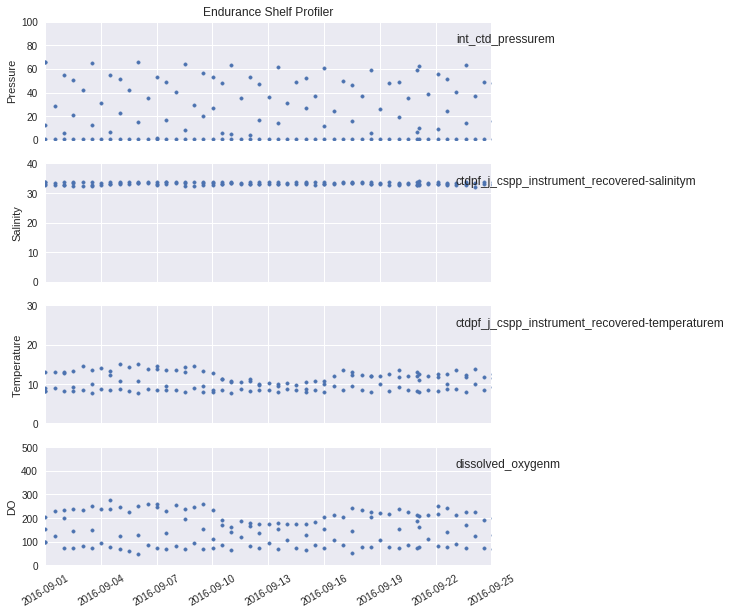

In [112]:
# Plot the data
fig,axs = plt.subplots(len(out), sharex=True, sharey=False, figsize=(8,10))

for jj in range(len(out)):
  axs[jj].scatter(out[jj]['time'], out[jj]['value'], marker='.')
  #axs[jj].set(ylabel=instruments[jj][5])
  #axs[jj].set_title('-'.join(instruments[jj][0:3]))
  axs[jj].text(.92, .9, ('%sm' % instruments[jj][-1]), horizontalalignment='left', verticalalignment='top', transform=axs[jj].transAxes)
  
plt.xlim(datetime.date(2016,9,1),datetime.date(2016,9,25))
plt.xticks(rotation=30)

axs[0].set_ylim(0,100)
axs[1].set_ylim(0,40)
axs[2].set_ylim(0,30)
axs[3].set_ylim(0,500)

axs[0].set_ylabel('Pressure')
axs[1].set_ylabel('Salinity')
axs[2].set_ylabel('Temperature')
axs[3].set_ylabel('DO')

axs[0].set_title('Endurance Shelf Profiler')




The data points for an entire month look sparse. Notice also that the len(data) is low compared to the next set of plots which are looking at a single day in Sept. 2016. 



In [102]:
import matplotlib.pyplot as plt
import numpy as np

Renaming our parameters

In [114]:
time=out[0]['time']
pressure=out[0]['value']
temperature=out[2]['value']
salinity=out[1]['value']
oxygen=out[3]['value']



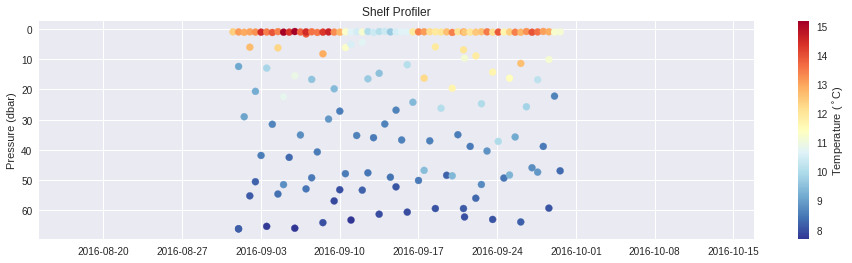

In [115]:
# Scatterplot of Temperature
fig,ax1 = plt.subplots(1,1,figsize=(16,4))
sc1 = ax1.scatter(time, pressure, c=temperature, cmap='RdYlBu_r') # Add s=2 to set the markersize
ax1.invert_yaxis() # Invert y axis
#ax1.set_xlim(time[0],time[-1]) # Set the time limits to match the dataset
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Shelf Profiler');





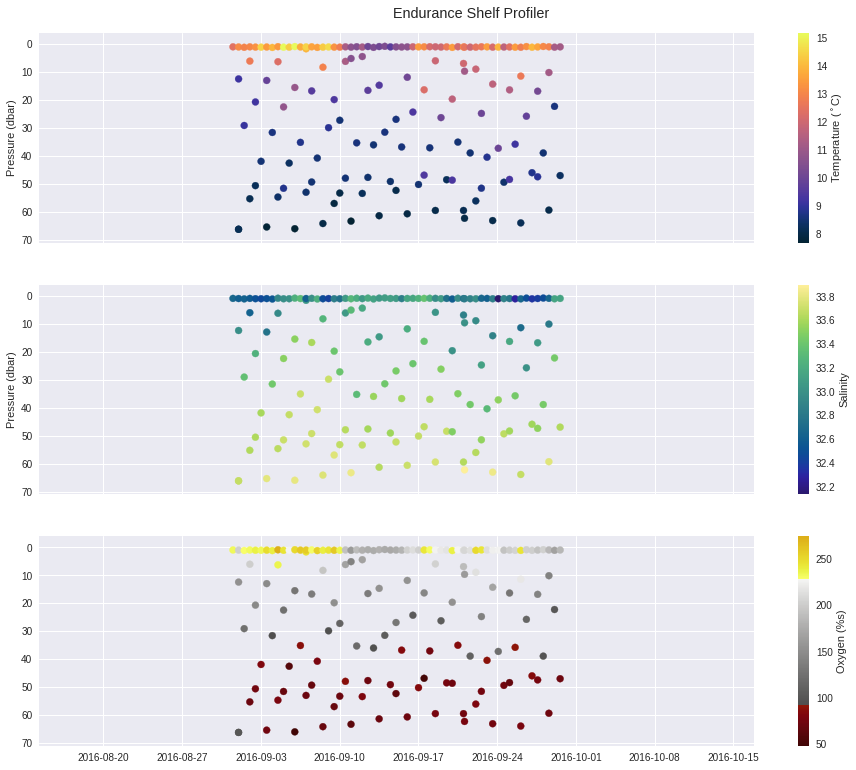

In [116]:
#Temperature, Salinity, Oxygen 
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, sharey=True,figsize=(16,12)) #sharey=True
sc1 = ax1.scatter(time, pressure, c=temperature, cmap=cmocean.cm.thermal) 
sc2 = ax2.scatter(time, pressure, c=salinity, cmap=cmocean.cm.haline) 
sc3 = ax3.scatter(time, pressure, c=oxygen, cmap=cmocean.cm.oxy)
# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
#ax1.set_xlim(time[0],time[-1]) # Set the time limits to match the dataset

# Add the colorbars
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical')
cbar.ax.set_ylabel('Oxygen (%s)')
cbar.update_ticks()
cbar.formatter.set_useOffset(False)


# Add labels & titles
ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')


fig.suptitle('Endurance Shelf Profiler')
fig.subplots_adjust(top=0.95);



Let's create vertical profile for all of September 2016. 

Text(0.5,0,u'Oxygen (\xb5mol kg-1)')

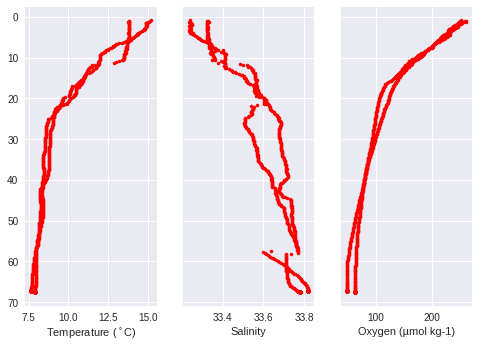

In [130]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,sharey=True)

ax1.plot(temperature,pressure,'r.')
ax1.invert_yaxis()
ax2.plot(salinity,pressure,'r.')
ax3.plot(oxygen,pressure,'r.')

ax1.set_xlabel('Temperature ($^\circ$C)')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('Oxygen (%s)' % ds['dissolved_oxygen'].units)


Using DataTeam help, slicing our datetime to find a single vertical profile. Using jsons not the best way to find a single up or down cast. 

In [0]:

starttime=datetime.datetime(2016, 9, 6, 0, 15, 41)
endtime=datetime.datetime(2016, 9, 6, 12, 15, 41)

x=[out[0]['time'][ii] for ii in range (len(out[0]['time'])) if out[0]['time'][ii]<endtime]
print(x[0],x[-1])

Instead, let's just take a day from September, the same day that corresponds to the Newport Line sampling at NH-05, Sept.6th.

In [125]:
# Specify additional parameters for the API request 
params = {
  'beginDT':'2016-09-06T00:10:00.000Z',
  'endDT':'2016-09-07T00:00:00.000Z',
  'limit':10000,   
}

In [126]:
# Grab the data for each instrument
out = []
for jj in range(len(instruments)):
  data_request_url ='/'.join((DATA_API,instruments[jj][0],instruments[jj][1],instruments[jj][2],instruments[jj][3],instruments[jj][4]))
  r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
  data = r.json()
  print(instruments[jj]) 
  print(len(data))
  time = []
  values = []
  for i in range(len(data)):
    time.append(ntp_seconds_to_datetime(data[i]['time']))
    values.append(data[i][instruments[jj][5]])
  out.append({'time':time,'value':values});

['CE02SHSP', 'SP001', '01-DOSTAJ000', 'recovered_cspp', 'dosta_abcdjm_cspp_instrument_recovered', 'int_ctd_pressure']
823
['CE02SHSP', 'SP001', '01-DOSTAJ000', 'recovered_cspp', 'dosta_abcdjm_cspp_instrument_recovered', 'ctdpf_j_cspp_instrument_recovered-salinity']
823
['CE02SHSP', 'SP001', '01-DOSTAJ000', 'recovered_cspp', 'dosta_abcdjm_cspp_instrument_recovered', 'ctdpf_j_cspp_instrument_recovered-temperature']
823
['CE02SHSP', 'SP001', '01-DOSTAJ000', 'recovered_cspp', 'dosta_abcdjm_cspp_instrument_recovered', 'dissolved_oxygen']
823


In [161]:
# Time Processing Routines 
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)


In [127]:
time=out[0]['time']
pressure=out[0]['value']
temperature=out[2]['value']
salinity=out[1]['value']
oxygen=out[3]['value']

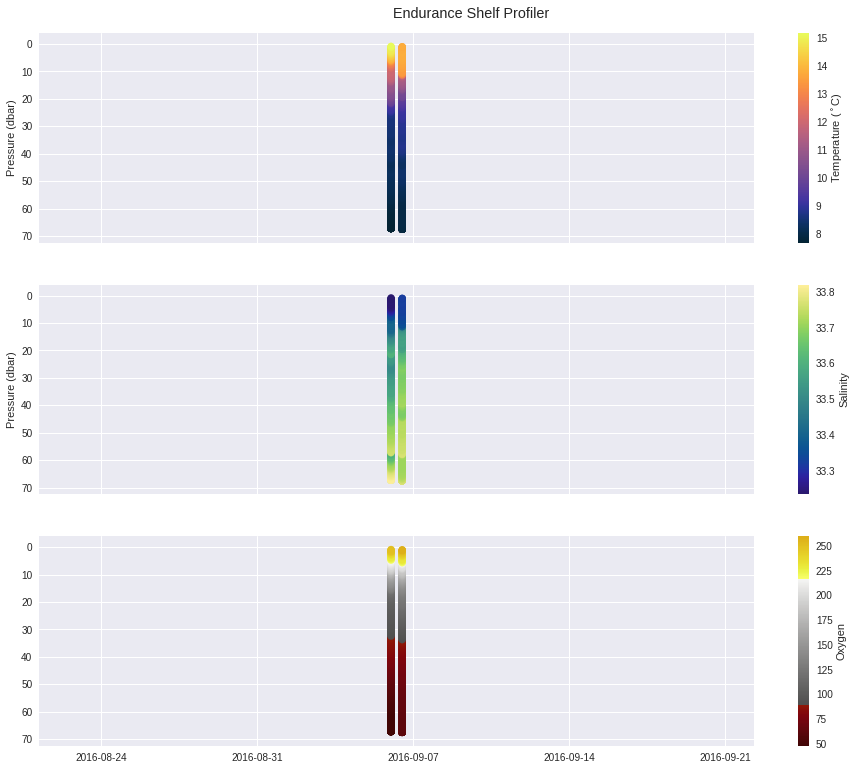

In [128]:
#Temperature, Salinity, Oxygen 
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, sharey=True,figsize=(16,12)) #sharey=True
sc1 = ax1.scatter(time, pressure, c=temperature, cmap=cmocean.cm.thermal) 
sc2 = ax2.scatter(time, pressure, c=salinity, cmap=cmocean.cm.haline) 
sc3 = ax3.scatter(time, pressure, c=oxygen, cmap=cmocean.cm.oxy)
# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
#ax1.set_xlim(time[0],time[-1]) # Set the time limits to match the dataset

# Add the colorbars
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical')
cbar.ax.set_ylabel('Oxygen')
cbar.update_ticks()
cbar.formatter.set_useOffset(False)


# Add labels & titles
ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')


fig.suptitle('Endurance Shelf Profiler')
fig.subplots_adjust(top=0.95);


Text(0.5,0,u'Oxygen (\xb5mol kg-1)')

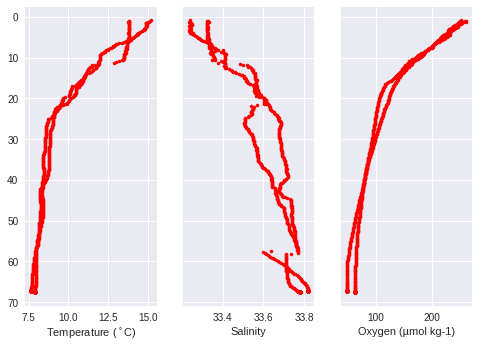

In [131]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,sharey=True)

ax1.plot(temperature,pressure,'r.')
ax1.invert_yaxis()
ax2.plot(salinity,pressure,'r.')
ax3.plot(oxygen,pressure,'r.')

ax1.set_xlabel('Temperature ($^\circ$C)')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('Oxygen (%s)' % ds['dissolved_oxygen'].units)

Something weird with salinity at depth.

Let's bring in the NH-05 data

In [132]:
import pandas as pd

p = pd.read_csv('https://marine.rutgers.edu/~sage/OOI_Data_Workshops/NHLineData.csv')

In [133]:

p['OIIOxygen'] = p['Oxygen'].astype(float)*44.66/1.02
p.head()

,ProjectID,CTD_Sample_Code,Station,Date,Pressure,Temperature,Conductivity,Salinity,Density,Oxygen,Fluorescence,Fluorescence mg/m3,Transmission,Transmission_volts,Comments,OIIOxygen
0,NH,090616NH05,NH05,6-Sep,1,14.5590,39.970596,32.693802,24.289301,6.9275,0.1145,NaN,92.797096,NaN,NaN,309.382140
1,NH,090616NH05,NH05,6-Sep,2,13.8585,39.651424,32.997101,24.668900,7.4273,0.1031,NaN,93.020103,NaN,NaN,331.703217
2,NH,090616NH05,NH05,6-Sep,3,13.7314,39.629433,33.085999,24.763599,7.6171,0.1263,NaN,92.793701,NaN,NaN,340.179675
3,NH,090616NH05,NH05,6-Sep,4,13.5697,39.619926,33.216801,24.897699,7.8969,0.1527,NaN,92.389099,NaN,NaN,352.675562
4,NH,090616NH05,NH05,6-Sep,5,13.5018,39.621887,33.277401,24.958300,7.7966,0.1721,NaN,91.200401,NaN,NaN,348.196150


In [134]:
NH5=p[p.Station == 'NH05']
NH5

,ProjectID,CTD_Sample_Code,Station,Date,Pressure,Temperature,Conductivity,Salinity,Density,Oxygen,Fluorescence,Fluorescence mg/m3,Transmission,Transmission_volts,Comments,OIIOxygen
0,NH,090616NH05,NH05,6-Sep,1,14.5590,39.970596,32.693802,24.289301,6.9275,0.1145,NaN,92.797096,NaN,NaN,309.382140
1,NH,090616NH05,NH05,6-Sep,2,13.8585,39.651424,32.997101,24.668900,7.4273,0.1031,NaN,93.020103,NaN,NaN,331.703217
2,NH,090616NH05,NH05,6-Sep,3,13.7314,39.629433,33.085999,24.763599,7.6171,0.1263,NaN,92.793701,NaN,NaN,340.179675
3,NH,090616NH05,NH05,6-Sep,4,13.5697,39.619926,33.216801,24.897699,7.8969,0.1527,NaN,92.389099,NaN,NaN,352.675562
4,NH,090616NH05,NH05,6-Sep,5,13.5018,39.621887,33.277401,24.958300,7.7966,0.1721,NaN,91.200401,NaN,NaN,348.196150
5,NH,090616NH05,NH05,6-Sep,6,13.3132,39.464691,33.294201,25.009300,7.7974,0.1953,NaN,90.347702,NaN,NaN,348.231884
6,NH,090616NH05,NH05,6-Sep,7,13.0844,39.282345,33.322399,25.076900,7.7151,0.2157,NaN,89.723999,NaN,NaN,344.556358
7,NH,090616NH05,NH05,6-Sep,8,12.8261,39.069767,33.348000,25.147600,7.5903,0.2079,NaN,89.468498,NaN,NaN,338.982802
8,NH,090616NH05,NH05,6-Sep,9,12.6291,38.919239,33.378399,25.209700,7.5685,0.1975,NaN,89.752296,NaN,NaN,338.009212
9,NH,090616NH05,NH05,6-Sep,10,12.5197,38.830006,33.389599,25.239599,7.5019,0.1717,NaN,91.061203,NaN,NaN,335.034863


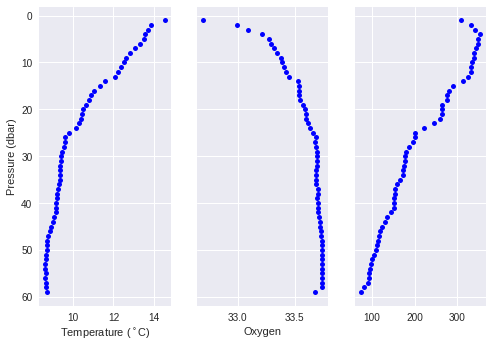

In [135]:
# Now let's create some profile plots from the Newport Line CTD at NH-05

peterpressure = NH5['Pressure'].values
petertemperature = NH5['Temperature'].values
petersalinity = NH5['Salinity'].values
peteroxygen=NH5['OIIOxygen'].values

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)

ax1.plot(petertemperature, peterpressure, 'b.', markersize=10)
ax2.plot(petersalinity, peterpressure, 'b.', markersize=10)
ax3.plot(peteroxygen,peterpressure,'b.',markersize=10)


ax1.set_xlabel('Temperature ($^\circ$C)')
ax2.set_xlabel('Salinity')
ax2.set_xlabel('Oxygen')

ax1.set_ylabel('Pressure (dbar)')

ax1.invert_yaxis()

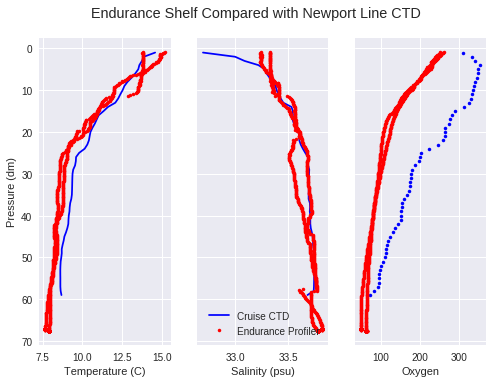

In [136]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)

ax1.plot(petertemperature,peterpressure,'b')
ax1.plot(temperature,pressure,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')



ax2.plot(petersalinity,peterpressure,'b',label='Cruise CTD')
ax2.plot(salinity,pressure,'r.',label='Endurance Profiler')
ax2.set_xlabel('Salinity (psu)')

ax3.plot(peteroxygen,peterpressure,'.b')
ax3.plot(oxygen,pressure,'.r')
ax3.set_xlabel('Oxygen')

ax1.invert_yaxis()

fig.suptitle('Endurance Shelf Compared with Newport Line CTD')
fig.subplots_adjust(top=0.9)

legend = ax2.legend(loc='lower right', shadow=True, fontsize='small')


Again, we see the high overlap between the temperature and salinity, but the offset in dissolved oxygen.

## Looking at Oregon Offshelf Shallow Profiler Mooring and NH-25 CTD Cast

Will use the OOI Synchronous Data Request API to pull out temperature, salinity, and dissolved oxygen data from Shallow Profiler (CE04OSPS-SF01B-2A-CTDPFA107). We will focus on the data collected on Sept. 20, 2016. The time frame was picked because we only had certain instances of NH-25 sampling in 2016. 

In [24]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# API Information
USERNAME ='OOIAPI-Y4VVWHNQL1983S'
TOKEN= 'Q9LA7YR8PRQSGK'
DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'

In [4]:
# Time Processing Routines 
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

In [5]:
# Instrument Information
site = 'CE04OSPS'
node = 'SF01B'
instrument = '2A-CTDPFA107'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

In [7]:
# Specify additional parameters for the API request 
params = {
  'beginDT':'2016-09-06T00:10:00.000Z',
  'endDT':'2016-09-07T00:00:00.000Z',
  'limit':10000,   
}

In [8]:
# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()
data

[{u'conductivity': 1433490,
  u'corrected_dissolved_oxygen': 257.00996011374474,
  u'corrected_dissolved_oxygen_qc_executed': 29,
  u'corrected_dissolved_oxygen_qc_results': 29,
  u'density': 1027.4002459768578,
  u'density_qc_executed': 29,
  u'density_qc_results': 13,
  u'driver_timestamp': 3682109399.274116,
  u'ext_volt0': 15600,
  u'ingestion_timestamp': 3682109401.8380003,
  u'internal_timestamp': 0.0,
  u'pk': {u'deployment': 3,
   u'method': u'streamed',
   u'node': u'SF01B',
   u'sensor': u'2A-CTDPFA107',
   u'stream': u'ctdpf_sbe43_sample',
   u'subsite': u'CE04OSPS',
   u'time': 3682109399.1763053},
  u'port_timestamp': 3682109399.1763053,
  u'practical_salinity': 33.92239947303173,
  u'practical_salinity_qc_executed': 29,
  u'practical_salinity_qc_results': 29,
  u'preferred_timestamp': u'port_timestamp',
  u'pressure': 713900,
  u'pressure_temp': 18617,
  u'seawater_conductivity': 3.4988944403098015,
  u'seawater_conductivity_qc_executed': 29,
  u'seawater_conductivity_qc_

In [9]:
instruments=[
    ['CE04OSPS','SF01B','2A-CTDPFA107','streamed','ctdpf_sbe43_sample','seawater_pressure'],
    ['CE04OSPS','SF01B','2A-CTDPFA107','streamed','ctdpf_sbe43_sample','seawater_temperature'],
    ['CE04OSPS','SF01B','2A-CTDPFA107','streamed','ctdpf_sbe43_sample','practical_salinity'],
    ['CE04OSPS','SF01B','2A-CTDPFA107','streamed','ctdpf_sbe43_sample','corrected_dissolved_oxygen'],
]

In [10]:
# Specify additional parameters for the API request 
params = {
  'beginDT':'2016-09-20T00:00:00.000Z',
  'endDT':'2016-09-21T00:00:00.000Z',
  'limit':10000,   
}

In [11]:
# Grab the data for each instrument
out = []
for jj in range(len(instruments)):
  data_request_url ='/'.join((DATA_API,instruments[jj][0],instruments[jj][1],instruments[jj][2],instruments[jj][3],instruments[jj][4]))
  r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
  data = r.json()
  print(instruments[jj]) 
  print(len(data))
  time = []
  values = []
  for i in range(len(data)):
    time.append(ntp_seconds_to_datetime(data[i]['time']))
    values.append(data[i][instruments[jj][5]])
  out.append({'time':time,'value':values});

['CE04OSPS', 'SF01B', '2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample', 'seawater_pressure']
10000
['CE04OSPS', 'SF01B', '2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample', 'seawater_temperature']
10000
['CE04OSPS', 'SF01B', '2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample', 'practical_salinity']
10000
['CE04OSPS', 'SF01B', '2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample', 'corrected_dissolved_oxygen']
10000


In [12]:
time=out[0]['time']
pressure=out[0]['value']
temperature=out[1]['value']
salinity=out[2]['value']
oxygen=out[3]['value']


In [14]:
whos

Variable                  Type        Data/Info
-----------------------------------------------
ASSET_API                 str         https://ooinet.oceanobser<...>atories.org/api/m2m/12587
DATA_API                  str         https://ooinet.oceanobser<...>/api/m2m/12576/sensor/inv
TOKEN                     str         Q9LA7YR8PRQSGK
USERNAME                  str         OOIAPI-Y4VVWHNQL1983S
VOCAB_API                 str         https://ooinet.oceanobser<...>g/api/m2m/12586/vocab/inv
cmocean                   module      <module 'cmocean' from '/<...>es/cmocean/__init__.pyc'>
data                      list        n=10000
data_request_url          str         https://ooinet.oceanobser<...>reamed/ctdpf_sbe43_sample
datetime                  module      <module 'datetime' (built-in)>
i                         int         9999
instrument                str         2A-CTDPFA107
instruments               list        n=4
jj                        int         3
method                    str 

In [13]:
!pip install cmocean
import cmocean

/usr/local/lib/python2.7/dist-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Looking at profile of temperature, salinity, and oxygen for Sept. 20, 2016.

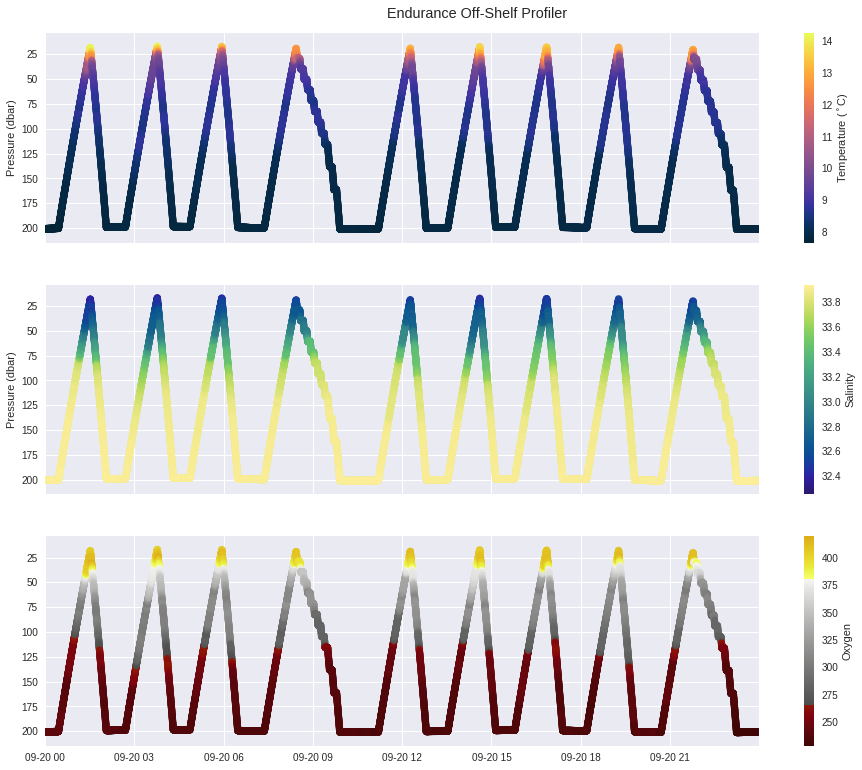

In [16]:
#Temperature, Salinity, Oxygen
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, sharey=True,figsize=(16,12)) #sharey=True
sc1 = ax1.scatter(time, pressure, c=temperature, cmap=cmocean.cm.thermal) 
sc2 = ax2.scatter(time, pressure, c=salinity, cmap=cmocean.cm.haline) 
sc3 = ax3.scatter(time, pressure, c=oxygen, cmap=cmocean.cm.oxy)
# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(time[0],time[-1]) # Set the time limits to match the dataset

# Add the colorbars
cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('Salinity')
cbar = fig.colorbar(sc3, ax=ax3, orientation='vertical')
cbar.ax.set_ylabel('Oxygen')
cbar.update_ticks()
cbar.formatter.set_useOffset(False)


# Add labels & titles
ax1.set_ylabel('Pressure (dbar)')
ax2.set_ylabel('Pressure (dbar)')


fig.suptitle('Endurance Off-Shelf Profiler')
fig.subplots_adjust(top=0.95);

Dissolved oxygen looks at little high (400 umol kg-1) for an off-shelf station in September. Let's plot some vertical plots of the same parameters. 

Text(0.5,0,u'Dissolved Oxygen')

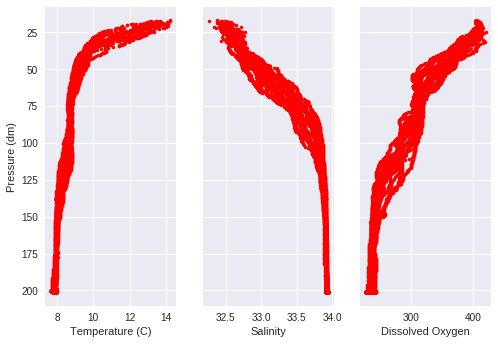

In [17]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,sharey=True)

ax1.plot(temperature,pressure,'r.')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')
ax2.plot(salinity,pressure,'r.')
ax2.set_xlabel('Salinity')
ax3.plot(oxygen,pressure,'r.')
ax3.set_xlabel('Dissolved Oxygen')

Now, lets bring in the data from NH-25 on Sept. 20, 2016. 

NH-25 Newport Line CTD Data.

In [18]:
import pandas as pd

p = pd.read_csv('https://marine.rutgers.edu/~sage/OOI_Data_Workshops/NHLineData.csv')

In [19]:
p['OIIOxygen'] = p['Oxygen'].astype(float)*44.66
p.head()

,ProjectID,CTD_Sample_Code,Station,Date,Pressure,Temperature,Conductivity,Salinity,Density,Oxygen,Fluorescence,Fluorescence mg/m3,Transmission,Transmission_volts,Comments,OIIOxygen
0,NH,090616NH05,NH05,6-Sep,1,14.5590,39.970596,32.693802,24.289301,6.9275,0.1145,NaN,92.797096,NaN,NaN,309.382140
1,NH,090616NH05,NH05,6-Sep,2,13.8585,39.651424,32.997101,24.668900,7.4273,0.1031,NaN,93.020103,NaN,NaN,331.703217
2,NH,090616NH05,NH05,6-Sep,3,13.7314,39.629433,33.085999,24.763599,7.6171,0.1263,NaN,92.793701,NaN,NaN,340.179675
3,NH,090616NH05,NH05,6-Sep,4,13.5697,39.619926,33.216801,24.897699,7.8969,0.1527,NaN,92.389099,NaN,NaN,352.675562
4,NH,090616NH05,NH05,6-Sep,5,13.5018,39.621887,33.277401,24.958300,7.7966,0.1721,NaN,91.200401,NaN,NaN,348.196150


In [20]:
NH25=p[p.Station == 'NH25']
NH25


,ProjectID,CTD_Sample_Code,Station,Date,Pressure,Temperature,Conductivity,Salinity,Density,Oxygen,Fluorescence,Fluorescence mg/m3,Transmission,Transmission_volts,Comments,OIIOxygen
59,NH,092016NH25,NH25,9/20/2016,1,15.2878,39.702538,31.850000,23.482800,5.9141,0.1169,NaN,92.305099,NaN,NaN,264.123714
60,NH,092016NH25,NH25,9/20/2016,2,15.3005,39.715057,31.850500,23.480400,5.9262,0.1260,NaN,92.413002,NaN,NaN,264.664088
61,NH,092016NH25,NH25,9/20/2016,3,15.2979,39.714382,31.851700,23.481899,5.9381,0.1205,NaN,92.417702,NaN,NaN,265.195540
62,NH,092016NH25,NH25,9/20/2016,4,15.2978,39.715576,31.852400,23.482500,5.9241,0.1261,NaN,92.403603,NaN,NaN,264.570303
63,NH,092016NH25,NH25,9/20/2016,5,15.2915,39.711945,31.854000,23.485100,5.9402,0.1219,NaN,92.314400,NaN,NaN,265.289325
64,NH,092016NH25,NH25,9/20/2016,6,15.2795,39.705315,31.857401,23.490400,5.9223,0.1250,NaN,92.285896,NaN,NaN,264.489912
65,NH,092016NH25,NH25,9/20/2016,7,15.2764,39.699574,31.854401,23.488800,5.9325,0.1319,NaN,92.178703,NaN,NaN,264.945445
66,NH,092016NH25,NH25,9/20/2016,8,15.2749,39.705345,31.860399,23.493700,5.9331,0.1376,NaN,92.119003,NaN,NaN,264.972256
67,NH,092016NH25,NH25,9/20/2016,9,15.2675,39.706017,31.866699,23.500200,5.9692,0.1323,NaN,92.089600,NaN,NaN,266.584478
68,NH,092016NH25,NH25,9/20/2016,10,15.2649,39.708302,31.870399,23.503700,5.9697,0.1267,NaN,91.991699,NaN,NaN,266.606796


Text(0.5,0.98,u'NH-25')

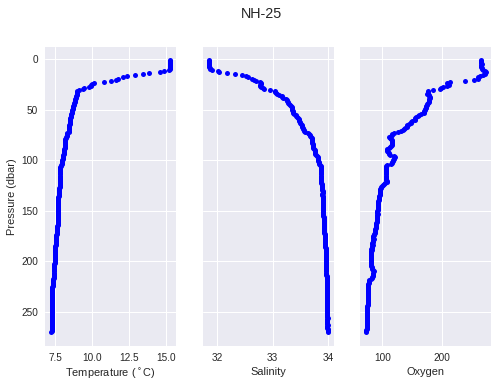

In [22]:
# Now let's create some profile plots from the Newport Line CTD at NH-05

peterpressure = NH25['Pressure'].values
petertemperature = NH25['Temperature'].values
petersalinity = NH25['Salinity'].values
peteroxygen=NH25['OIIOxygen'].values

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)

ax1.plot(petertemperature, peterpressure, 'b.', markersize=10)
ax2.plot(petersalinity, peterpressure, 'b.', markersize=10)
ax3.plot(peteroxygen,peterpressure,'b.',markersize=10)


ax1.set_xlabel('Temperature ($^\circ$C)')
ax2.set_xlabel('Salinity')
ax3.set_xlabel('Oxygen')

ax1.set_ylabel('Pressure (dbar)')

ax1.invert_yaxis()

fig.suptitle('NH-25')

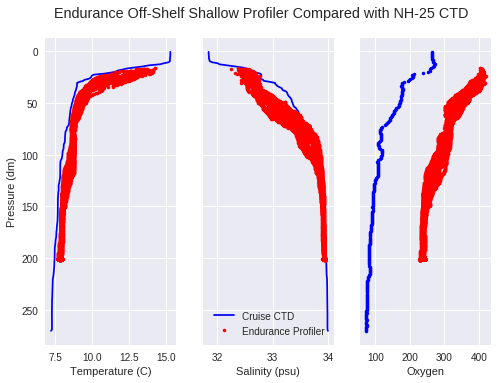

In [23]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)

ax1.plot(petertemperature,peterpressure,'b')
ax1.plot(temperature,pressure,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')



ax2.plot(petersalinity,peterpressure,'b',label='Cruise CTD')
ax2.plot(salinity,pressure,'r.',label='Endurance Profiler')
ax2.set_xlabel('Salinity (psu)')

ax3.plot(peteroxygen,peterpressure,'.b')
ax3.plot(oxygen,pressure,'.r')
ax3.set_xlabel('Oxygen')

ax1.invert_yaxis()

fig.suptitle('Endurance Off-Shelf Shallow Profiler Compared with NH-25 CTD')
fig.subplots_adjust(top=0.9)

legend = ax2.legend(loc='lower right', shadow=True, fontsize='small')

Again, we see some good overlap in temperature and salinity. Noticably, the profiler stops at 200 m. The oxygen is more troubling. The profiler is consistently higher than the NH-25 CTD. 

Luckily, we have a surface mooring near the off-shelf profiler. Let's take a look at the dissolved oxygen at the surfacing mooring for September 2016. 

## Offshelf Surface Mooring and Dissolved Oxygen

Let's make a quick Synchromous request (quick and dirty!) and look at the dissolved oxygen values at the surface mooring (deployed at 7 m) near the off-shore profiler on the Endurance Array. Are the values similar? 

In [43]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# API Information
USERNAME ='OOIAPI-Y4VVWHNQL1983S'
TOKEN= 'Q9LA7YR8PRQSGK'
DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'

In [33]:
# First, we need to add some more Python libraries
import requests
import datetime
import time

In [34]:
# Instrument Information
site = 'CE04OSSM'
node = 'RID27'
instrument = '04-DOSTAD000'
method = 'recovered_host'
stream = 'dosta_abcdjm_dcl_instrument_recovered'

data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))



params = {
  'beginDT':'2016-09-01T00:00:00.000Z',
  'endDT':'2016-09-30T00:00:00.000Z',
  'limit':1000,   
}

In [35]:
# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

In [36]:
data[0]

{u'blue_amplitude': 501.8999938964844,
 u'blue_phase': 39.86199951171875,
 u'calibrated_phase': 30.586000442504883,
 u'ctdbp_cdef_dcl_instrument_recovered-practical_salinity': 31.845168815174052,
 u'ctdbp_cdef_dcl_instrument_recovered-temp': 17.696300506591797,
 u'dcl_controller_timestamp': u'empty',
 u'dissolved_oxygen': 225.81375566766417,
 u'dissolved_oxygen_qc_executed': 29,
 u'dissolved_oxygen_qc_results': 29,
 u'dosta_abcdjm_cspp_tc_oxygen': 279.63038184938506,
 u'dosta_abcdjm_cspp_tc_oxygen_qc_executed': 13,
 u'dosta_abcdjm_cspp_tc_oxygen_qc_results': 13,
 u'driver_timestamp': 3717572133.774056,
 u'estimated_oxygen_concentration': 301.1319885253906,
 u'estimated_oxygen_concentration_qc_executed': 9,
 u'estimated_oxygen_concentration_qc_results': 9,
 u'estimated_oxygen_saturation': 101.58000183105469,
 u'estimated_oxygen_saturation_qc_executed': 1,
 u'estimated_oxygen_saturation_qc_results': 1,
 u'ingestion_timestamp': 3717572137.947,
 u'internal_timestamp': 0.0,
 u'optode_temper

In [38]:
# Time Processing Routine
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

In [40]:
# Process the data
time = []
oxygen= []
pressure=[]
for i in range(len(data)):
  time.append(ntp_seconds_to_datetime(data[i]['time']))
  oxygen.append(data[i]['dissolved_oxygen'])
  


In [0]:
import numpy as np 

Text(0,0.5,u'Oxygen')

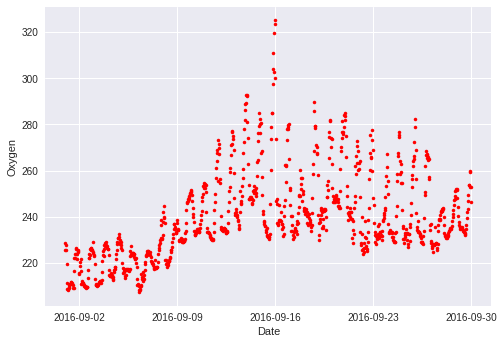

In [45]:
plt.plot_date(time, oxygen, 'r.', label='Oxygen')
plt.xlabel('Date')
plt.ylabel('Oxygen')


In [49]:
np.mean(oxygen)

239.3931918585411

Looking at a quick plot of surface mooring time series, we see a peak in dissolved oxygen on Sept 16, 2016, but with a mean of 239 umol kg-1. These numbers are much lower than the surface measurements from off-shore shallow profiler. Something amiss with the profiler oxygen readings?

## Conclusions

Some general conclusions and future data quality:

1. Certain biological parameters should be examined in detail and values should be quality controlled based on region and season. 
2. Co-located data needs to have it's own quality control. In our case, Winkler titrations could be used for DO values to compare with our own CTD.
3. When requesting data, make sure to examine annotations and any data gaps. Think about which way you want to access the data. 
4. Examine other biological parameters at these instruments and compare to cruise data.
5. The Endurance Array will complement work done by the Peterson group, especially considering we can only collect physical data when the weather permits. The instruments are out there when we can't be!

In [50]:
print ('k bye')

k bye
